# Method: RC 
# Dataset: Lorenz-96, F = 8
# Purpose: Prediction of Small Dataset

# 1. Set-up

In [1]:
# GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Package
import sys
sys.path.append("../..")

In [2]:
from create_data import load_data
from utils import * # Number of testing samples
import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy import sparse

import jax
import jax.numpy as jnp
from jax import value_and_grad
from jax.numpy import tanh
from jax.example_libraries import optimizers

In [3]:
SEED = 42

In [4]:
train, test = load_data("Lorenz 96, F = 8", "../../data/lorenz8", 0.5)

In [5]:
train.data = train.data[:18000]
train.time = train.time[:18000]

In [6]:
print(f"Train size: {train.data.shape}")
print(f"Test size: {test.data.shape}")

Train size: (18000, 40)
Test size: (90000, 40)


**Create test set**

In [7]:
L_forecast_test = 400   # steps to forecast forward (when testing)

In [8]:
np.random.seed(1)

data_test = test.data

T_test, data_dim = data_test.shape
possible_idx = T_test - (L_forecast_test + 1) # minus number of steps forward, and the warm-up period
T_indices = np.random.randint(0, possible_idx, size = NUM_TEST)

t_past_batch = np.repeat(T_indices[:, None], WARM_UP_TEST, axis = 1).astype(int) # 200 warmup 
t_pred_batch = (T_indices[:, None] + np.arange(1, 1 + L_forecast_test)[None, :].astype(int))

X_test = data_test[t_past_batch]
y_test = data_test[t_pred_batch]

In [9]:
print(f"Test input size: {X_test.shape}")  # Number of test points x input length x dim
print(f"Test output size: {y_test.shape}") # Number of test points x horizon x dim

Test input size: (100, 2000, 40)
Test output size: (100, 400, 40)


# 2. RC Implementation

In [10]:
def get_parameters(nn_size, connectivity, spec_radius, lambd, 
                   seed, batch_size, num_epoch, lr_schedule = [1e-4], 
                   early_stopping = EARLY_STOPPING):
    """
    Returns trained parameters (beta, intercept) and hidden layer values
    """
    def initialize_coef():
        """
        Initializes W_in and W. 
        W_in size = nn_size x data_dim
        W size = nn_size x nn_size
        """
        start = time()

        # Generate input -> hidden unit weights
        W_in = 2 * (np.random.rand(nn_size, data_dim) - 0.5) 
        W_in = W_in / (4 * np.sqrt(data_dim))

        # Generate hidden -> hidden unit weights
        # Considers connectivity to make the matrix sparse
        start_mat = time()
        rows = np.concatenate([np.full(connectivity, i) for i in range(nn_size)])
        cols = np.concatenate([np.random.choice(range(nn_size), size = connectivity, replace = False) for _ in range(nn_size)])
        vals = np.random.uniform(low = -omega, high = omega, size = (nn_size * connectivity))
        W = sparse.csr_matrix((vals, (rows, cols)), shape = (nn_size, nn_size))
        end_mat = time()
        print(f"W generated. Time taken: {end_mat - start_mat:.2f}s")

        # Calculate eigenvalues for scaling of matrix
        print("Calculating eigenvalue")
        e_start = time()
        eigenvals = sparse.linalg.eigs(W, which = "LM", return_eigenvectors = False, k = 1)
        max_eigen = np.abs(eigenvals)
        e_end = time()
        print(f"Eigenvalue calculated. Time taken: {e_end - e_start:.2f}s")

        # Scale matrix by spectral radius
        W = W / max_eigen * spec_radius # scale the matrix W by its spectral radius
        W = sparse.csr_matrix(W)
        
        end = time()
        print(f"W and W_in generated. Time taken: {end-start:.2f}s")
        print()
        
        return W_in, W
    
    def generate_hidden_states(W_in, W):
        """ 
        Generate hidden states (z) values
        hidden_states size = data_size x nn_size 
        """
        start = time()
        
        print("Generating z values...")
        indiv_z = np.zeros(shape = nn_size)
        hidden_states = np.zeros((train_size, nn_size))
        
        for t in range(train_size):  
            indiv_z = (1 - alpha) * indiv_z + \
                alpha * np.tanh(W_in @ x[t] + W @ indiv_z)
            hidden_states[t, :] = indiv_z
        end = time()
        print(f"z values generated. Time taken: {end-start:.2f}s")
        
        return hidden_states
    
    def mse(y, y_pred):
        return jnp.mean((y_pred - y)**2)
    
    @jax.jit
    def mse_loss(params, x, y):
        """
        returns mean squared error
        """
        beta, intercept = params
        pred = x @ beta + intercept
        return mse(pred, y) + np.mean(beta**2) * lambd / 2 + np.mean(intercept**2) * lambd / 2
    
    def validation_loss(params, x_val, y_val):
        beta, intercept = params
        num_data_test, trans, data_dim = x_val.shape # testing ex, # steps used (transient), dim of data

        def prediction(inp):
            """
            Returns the mean of one of the testing input

            mean will be a length_to_test x data_dim vector
            """
            z = np.zeros((nn_size // 2, ))
            for i in range(trans):
                z = (1 - alpha) * z + alpha * np.tanh(W_in @ inp[i] + W @ z)

            mus = []
            stddevs = []

            x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next | size = dim_data
            mus.append(x)

            for _ in range(L_forecast_test - 1):
                z = (1 - alpha) * z + alpha * np.tanh(W_in @ x + W @ z)
                x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next
                mus.append(x)

            return mus

        mean_list = []
        sd_list = []

        for i in range(num_data_test):
            pred = prediction(x_val[i])
            mean_list.append(pred)

        return mse(mean_list, y_val)

    def training(x, y):
        """ 
        Trains regression of y~x using SGD. 
        Returns parameters (beta, intercept) where 
        beta, intercept -> weights to determine the mean
        
        beta size = nn_size x data_dim
        intercept = data_dim (will be added for each training data)
        
        should predict a mu with train_size x data_dim (\mu per dimension per datapoint)
        and a sigma with train_size x 1 (single \sigma for all dimensions per datapoint)
        """
        
        @jax.jit
        def step(opt_state, x, y):
            params = get_params(opt_state)
            value, g = value_and_grad(mse_loss)(params, x, y)
            opt_state = opt_update(0, g, opt_state)
            return get_params(opt_state), opt_state, value

        start = time()
        
        # Plot loss
        loss_train_traj = []
        loss_train_all_traj = []
        
        # Init parameters
        beta = np.random.normal(0, 1 / np.sqrt(nn_size), size = (nn_size, data_dim))
        intercept = np.random.normal(0, 1 / np.sqrt(nn_size * 2), size = (data_dim, ))
        
        t_size = int(1. * train_size)
        
        overall_best_mse = 9999999
        
        for i, lr in enumerate(lr_schedule):
            opt_init, opt_update, get_params = optimizers.adam(step_size = lr) 
            opt_state = opt_init([beta, intercept])
            
            # For early stopping
            best_state = opt_state
            counter = 0 
            best_val_loss = 9999999
            
            for epoch in range(num_epoch[i]):
                e_start = time()
                
                T_indices = np.arange(train_size)
                np.random.shuffle(T_indices)

                loss_epoch_train = []
                for k in range(t_size // batch_size + 1):
                    t_start = T_indices[np.arange(k * batch_size, (k+1) * batch_size).astype(int) % len(T_indices)]
                    x_batch = x[t_start]
                    y_batch = y[t_start]

                    params, opt_state, l = step(opt_state, x_batch, y_batch)
                    loss_epoch_train.append(l)
                
                
                loss_train_all_traj += loss_epoch_train
                mse_train = np.mean(loss_epoch_train)
                loss_train_traj.append(mse_train)
                
                e_end = time()
                
                if mse_train < best_val_loss:
                    best_val_loss = mse_train
                    counter = 0
                    best_state = opt_state
                else:
                    counter += 1
                    
                if (epoch + 1) % 10 == 0 or (counter == 0 and epoch > 49):
                    print(f"Epoch {epoch + 1}: Train time = {e_end - e_start:.2f} | Train Loss = {mse_train:.7f}", end = " ")
                    print()
                if counter == early_stopping:
                    print(f"EARLY STOPPING. Epoch {epoch + 1}: Train loss = {mse_train:.7f}")
                    break
            
            print(f"Best Training MSE: {best_val_loss:.7f}") 
            
            if best_val_loss < overall_best_mse:
                print("IMPROVED VALIDATION MSE")
                overall_best_mse = best_val_loss
                overall_best_state = best_state
            
            beta, intercept = get_params(overall_best_state)
            print()
        
        end = time()
        print(f"Total time: {end - start:.2f}")
        
        return get_params(overall_best_state) # beta, intercept
    
    start = time()
   
    x, y = train.data[:-1], train.data[1:]
    copy_x, copy_y = x, y 
    train_size, data_dim = x.data.shape
       
    np.random.seed(seed)
    W_in, W = initialize_coef()
    z = generate_hidden_states(W_in, W)

    # Want to regression Y ~ X ==> Y ~ [z, z**2]
    final_y = y[transient:]
    final_z = z[transient:]
    print("Concatenating z with z**2", end = " "); concat_start = time()
    final_z = np.concatenate([final_z, final_z**2], axis = 1) # shape: train_size x (nn_size*2)
    concat_end = time()
    print(f"Contenation complete. Time taken: {concat_end-concat_start:.2f}s", end = "\n\n")
    
    train_size, nn_size = final_z.shape
    
    params = training(final_z, final_y)
    end = time()
    print(f"Complete. Time taken: {end - start:.2f}s")
    
    return params, (final_z, W_in, W)

In [11]:
def get_test_pred(data_test, nn_size, params, W_in, W):   
    beta, intercept = params
    num_data_test, trans, data_dim = data_test.shape # testing ex, # steps used (transient), dim of data
    
    def prediction(inp):
        """
        Returns the mean of one of the testing input
        
        mean will be a length_to_test x data_dim vector
        """
        
        z = np.zeros((nn_size, ))
        for i in range(trans):
            z = (1 - alpha) * z + alpha * np.tanh(W_in @ inp[i] + W @ z)
        
        mus = []
        stddevs = []
        
        x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next | size = dim_data
        mus.append(x)
        
        for _ in range(L_forecast_test - 1):
            z = (1 - alpha) * z + alpha * np.tanh(W_in @ x + W @ z)
            x = beta.T @ np.concatenate([z, z**2]) + intercept # output / input_of_next
            mus.append(x)
        
        return mus
    
    start = time()
    
    mean_list = []
    sd_list = []
    
    for i in range(num_data_test):
        pred = prediction(data_test[i])
        mean_list.append(pred)

        if (i+1) % 10 == 0:
            print(f"{(i+1) / num_data_test * 100:.2f}% done")
    
    end = time()
    print(f"Testing complete. Time taken: {end - start:.2f}")
    return np.array(mean_list)

# 3. Parameter tuning

There are 4 parameters to tune
- nn_size [3000, 6000, 9000, 12000, 150000] - size of the hidden layer
- connectivity [4, 8] - sparseness of W
- spec_radius [0.1, 0.3, 0.5, 0.7] - spectral radius (scale) of W
- lambda [1e-2, 1e-4, 1e-6] - ridge regression penalty

Through initial expeirments, it was shown that the value of lambda does not greatly affect the results. As a full grid search will be computationally expensive, nn_size is first tuned. Then, a lambda value is chosen, followed by the spectral radius and lastly, the optimal connectivity.

## 3.1 nn_size

**Parameters**
- nn_size = [3000, 6000, 9000, 12000, 15000]
- connectivity = 4
- spec_radius = 0.5 
- lambda = 1e-4

In [13]:
ridge_penalty = 1e-4
connectivity = 4
spec_radius = 0.5
transient = 200  # points to ignore to allow system to stabilise
omega = 1         # scale of the values of matrix W
alpha = 1         # hidden state memory
b_size = 200

### 3.1.1 nn_size = 3000

In [77]:
nn_size = 3000
lr_list = [1e-4]
epoch_list = [400]

In [78]:
# Testing with validation
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 1.34s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 0.48s
W and W_in generated. Time taken: 2.18s

Generating z values...
z values generated. Time taken: 4.28s
Concatenating z with z**2 Contenation complete. Time taken: 0.60s

Epoch 10: Train time = 0.56 | Train Loss = 0.0020772 
Epoch 20: Train time = 0.57 | Train Loss = 0.0010595 
Epoch 30: Train time = 0.51 | Train Loss = 0.0005870 
Epoch 40: Train time = 0.50 | Train Loss = 0.0003407 
Epoch 50: Train time = 0.54 | Train Loss = 0.0002050 
Epoch 51: Train time = 0.57 | Train Loss = 0.0001953 
Epoch 52: Train time = 0.54 | Train Loss = 0.0001860 
Epoch 53: Train time = 0.54 | Train Loss = 0.0001773 
Epoch 54: Train time = 0.56 | Train Loss = 0.0001689 
Epoch 55: Train time = 0.56 | Train Loss = 0.0001611 
Epoch 56: Train time = 0.55 | Train Loss = 0.0001537 
Epoch 57: Train time = 0.57 | Train Loss = 0.0001466 
Epoch 58: Train time = 0.55 | Train Loss = 0.0001400 
Epoch 59: Train time = 0.56 | Trai

In [79]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 77.38


In [81]:
save_obj(mean_pred, "results/rc", "3_1_1_mu_preds.pkl")

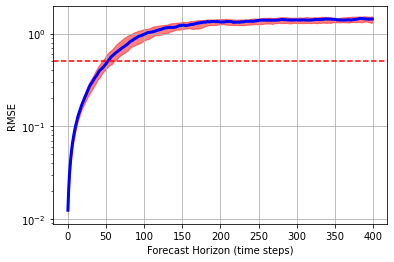

It takes around t = 0.52 for mean error to exceed 0.5


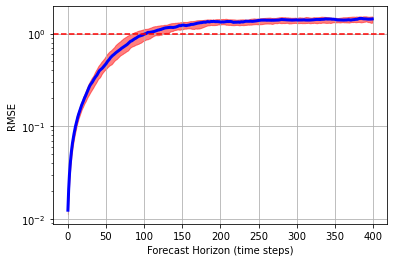

It takes around t = 1.03 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.184
Median NRMSE at t = 0.5: 0.472
Median NRMSE at t = 1: 0.982
Median NRMSE at t = 2: 1.330
Median NRMSE at t = 3: 1.404


In [80]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.2 nn_size = 6000

In [82]:
nn_size = 6000
lr_list = [1e-4]
epoch_list = [400]

In [84]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 5.07s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 1.64s
W and W_in generated. Time taken: 7.74s

Generating z values...
z values generated. Time taken: 5.18s
Concatenating z with z**2 Contenation complete. Time taken: 1.32s

Epoch 10: Train time = 1.17 | Train Loss = 0.0008649 
Epoch 20: Train time = 1.03 | Train Loss = 0.0003165 
Epoch 30: Train time = 1.03 | Train Loss = 0.0001468 
Epoch 40: Train time = 0.96 | Train Loss = 0.0000772 
Epoch 50: Train time = 1.04 | Train Loss = 0.0000440 
Epoch 51: Train time = 1.02 | Train Loss = 0.0000418 
Epoch 52: Train time = 1.04 | Train Loss = 0.0000397 
Epoch 53: Train time = 1.01 | Train Loss = 0.0000377 
Epoch 54: Train time = 1.02 | Train Loss = 0.0000359 
Epoch 55: Train time = 1.02 | Train Loss = 0.0000341 
Epoch 56: Train time = 1.01 | Train Loss = 0.0000325 
Epoch 57: Train time = 1.02 | Train Loss = 0.0000310 
Epoch 58: Train time = 1.01 | Train Loss = 0.0000295 
Epoch 59: Train time = 1.00 | Trai

In [85]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 120.68


In [86]:
save_obj(mean_pred, "results/rc", "3_1_2_mu_preds.pkl")

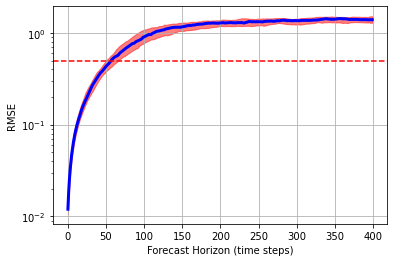

It takes around t = 0.57 for mean error to exceed 0.5


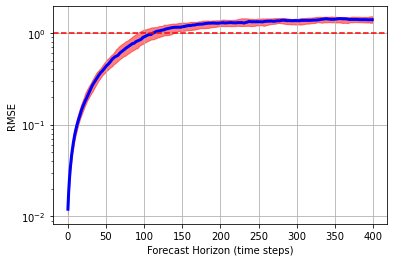

It takes around t = 1.13 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.161
Median NRMSE at t = 0.5: 0.432
Median NRMSE at t = 1: 0.904
Median NRMSE at t = 2: 1.285
Median NRMSE at t = 3: 1.360


In [87]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.3 nn_size = 9000

In [88]:
nn_size = 9000
lr_list = [1e-4]
epoch_list = [400]

In [89]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 11.70s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 2.30s
W and W_in generated. Time taken: 15.98s

Generating z values...
z values generated. Time taken: 9.98s
Concatenating z with z**2 Contenation complete. Time taken: 1.85s

Epoch 10: Train time = 1.38 | Train Loss = 0.0004673 
Epoch 20: Train time = 1.49 | Train Loss = 0.0001517 
Epoch 30: Train time = 1.36 | Train Loss = 0.0000683 
Epoch 40: Train time = 1.45 | Train Loss = 0.0000358 
Epoch 50: Train time = 1.37 | Train Loss = 0.0000208 
Epoch 51: Train time = 1.44 | Train Loss = 0.0000199 
Epoch 52: Train time = 1.53 | Train Loss = 0.0000189 
Epoch 53: Train time = 1.52 | Train Loss = 0.0000181 
Epoch 54: Train time = 1.54 | Train Loss = 0.0000173 
Epoch 55: Train time = 1.53 | Train Loss = 0.0000165 
Epoch 56: Train time = 1.54 | Train Loss = 0.0000158 
Epoch 57: Train time = 1.51 | Train Loss = 0.0000152 
Epoch 58: Train time = 1.50 | Train Loss = 0.0000146 
Epoch 59: Train time = 1.54 | Tr

In [90]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 146.05


In [91]:
save_obj(mean_pred, "results/rc", "3_1_3_mu_preds.pkl")

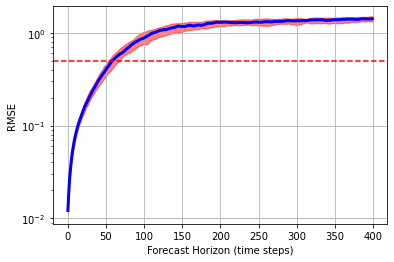

It takes around t = 0.59 for mean error to exceed 0.5


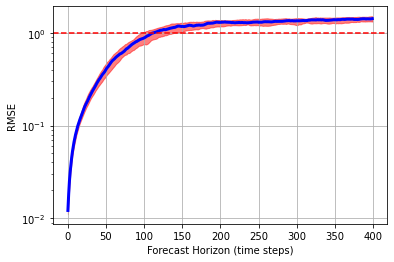

It takes around t = 1.13 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.146
Median NRMSE at t = 0.5: 0.404
Median NRMSE at t = 1: 0.882
Median NRMSE at t = 2: 1.296
Median NRMSE at t = 3: 1.350


In [92]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.4 nn_size = 12000

In [93]:
nn_size = 12000
lr_list = [1e-4]
epoch_list = [400]

In [94]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 18.81s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 8.92s
W and W_in generated. Time taken: 30.97s

Generating z values...
z values generated. Time taken: 10.23s
Concatenating z with z**2 Contenation complete. Time taken: 1.86s

Epoch 10: Train time = 2.05 | Train Loss = 0.0002958 
Epoch 20: Train time = 2.03 | Train Loss = 0.0000922 
Epoch 30: Train time = 2.06 | Train Loss = 0.0000418 
Epoch 40: Train time = 1.97 | Train Loss = 0.0000225 
Epoch 50: Train time = 2.06 | Train Loss = 0.0000137 
Epoch 51: Train time = 2.07 | Train Loss = 0.0000132 
Epoch 52: Train time = 2.05 | Train Loss = 0.0000128 
Epoch 53: Train time = 2.04 | Train Loss = 0.0000122 
Epoch 54: Train time = 2.04 | Train Loss = 0.0000118 
Epoch 55: Train time = 2.06 | Train Loss = 0.0000114 
Epoch 56: Train time = 2.04 | Train Loss = 0.0000110 
Epoch 57: Train time = 2.05 | Train Loss = 0.0000107 
Epoch 58: Train time = 2.05 | Train Loss = 0.0000102 
Epoch 59: Train time = 2.05 | T

In [95]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 224.37


In [96]:
save_obj(mean_pred, "results/rc", "3_1_4_mu_preds.pkl")

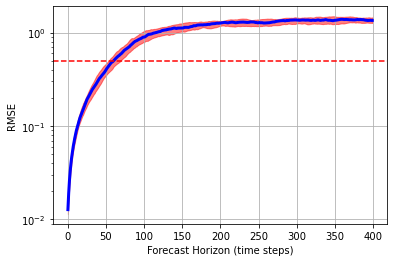

It takes around t = 0.60 for mean error to exceed 0.5


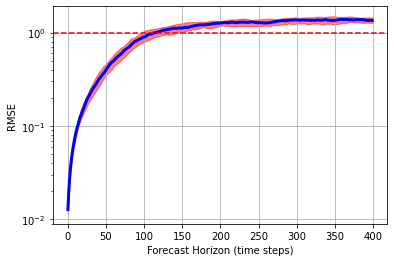

It takes around t = 1.15 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.150
Median NRMSE at t = 0.5: 0.400
Median NRMSE at t = 1: 0.896
Median NRMSE at t = 2: 1.267
Median NRMSE at t = 3: 1.362


In [97]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.1.5 nn_size = 15000

In [98]:
nn_size = 15000
lr_list = [1e-4]
epoch_list = [400]

In [99]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 38.91s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 6.32s
W and W_in generated. Time taken: 50.54s

Generating z values...
z values generated. Time taken: 18.13s
Concatenating z with z**2 Contenation complete. Time taken: 2.65s

Epoch 10: Train time = 2.73 | Train Loss = 0.0002025 
Epoch 20: Train time = 2.65 | Train Loss = 0.0000623 
Epoch 30: Train time = 2.55 | Train Loss = 0.0000285 
Epoch 40: Train time = 2.57 | Train Loss = 0.0000159 
Epoch 50: Train time = 2.71 | Train Loss = 0.0000104 
Epoch 51: Train time = 2.71 | Train Loss = 0.0000101 
Epoch 52: Train time = 2.72 | Train Loss = 0.0000097 
Epoch 53: Train time = 2.70 | Train Loss = 0.0000094 
Epoch 54: Train time = 2.74 | Train Loss = 0.0000092 
Epoch 55: Train time = 2.64 | Train Loss = 0.0000089 
Epoch 56: Train time = 2.65 | Train Loss = 0.0000086 
Epoch 57: Train time = 2.64 | Train Loss = 0.0000085 
Epoch 58: Train time = 2.65 | Train Loss = 0.0000083 
Epoch 59: Train time = 2.66 | T

In [100]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 232.95


In [101]:
save_obj(mean_pred, "results/rc", "3_1_5_mu_preds.pkl")

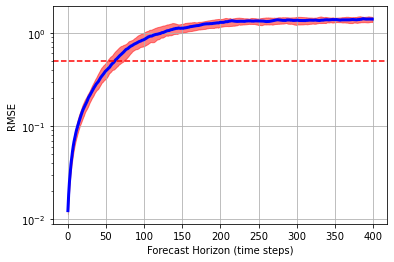

It takes around t = 0.62 for mean error to exceed 0.5


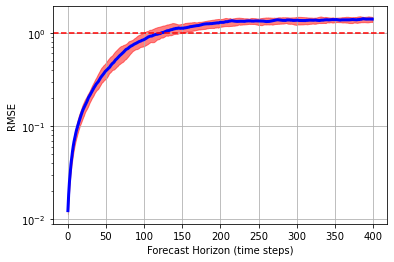

It takes around t = 1.23 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.151
Median NRMSE at t = 0.5: 0.392
Median NRMSE at t = 1: 0.847
Median NRMSE at t = 2: 1.296
Median NRMSE at t = 3: 1.363


In [102]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.2 lambda (ridge penalty)

**Parameters**
- nn_size = 12000
- connectivity = 4
- spec_radius = 0.5
- lambda = [1e-2, 1e-4, 1e-6]

In [103]:
nn_size = 15000
lr_list = [1e-4]
epoch_list = [400]

### 3.2.1 lambda = 1e-2

In [104]:
ridge_penalty = 1e-2

In [105]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 32.37s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 4.30s
W and W_in generated. Time taken: 41.67s

Generating z values...
z values generated. Time taken: 13.60s
Concatenating z with z**2 Contenation complete. Time taken: 2.48s

Epoch 10: Train time = 2.67 | Train Loss = 0.0002029 
Epoch 20: Train time = 2.59 | Train Loss = 0.0000626 
Epoch 30: Train time = 2.65 | Train Loss = 0.0000288 
Epoch 40: Train time = 2.55 | Train Loss = 0.0000162 
Epoch 50: Train time = 2.69 | Train Loss = 0.0000107 
Epoch 51: Train time = 2.74 | Train Loss = 0.0000104 
Epoch 52: Train time = 2.63 | Train Loss = 0.0000100 
Epoch 53: Train time = 2.70 | Train Loss = 0.0000097 
Epoch 54: Train time = 2.68 | Train Loss = 0.0000095 
Epoch 55: Train time = 2.71 | Train Loss = 0.0000092 
Epoch 56: Train time = 2.75 | Train Loss = 0.0000089 
Epoch 57: Train time = 2.71 | Train Loss = 0.0000088 
Epoch 58: Train time = 2.72 | Train Loss = 0.0000086 
Epoch 59: Train time = 2.72 | T

In [106]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 211.92


In [107]:
save_obj(mean_pred, "results/rc", "3_2_1_mu_preds.pkl")

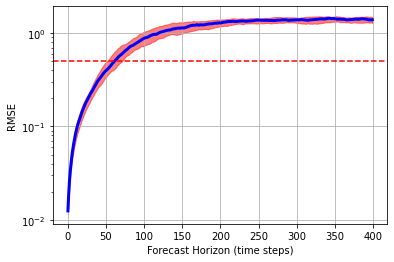

It takes around t = 0.61 for mean error to exceed 0.5


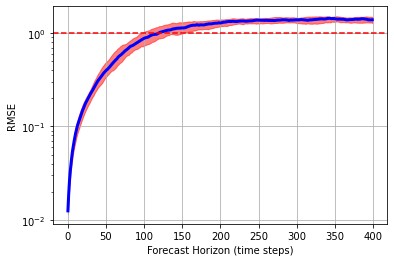

It takes around t = 1.20 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.153
Median NRMSE at t = 0.5: 0.397
Median NRMSE at t = 1: 0.878
Median NRMSE at t = 2: 1.281
Median NRMSE at t = 3: 1.385


In [108]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.2.2 lambda = 1e-4
Already done is 3.1.5

### 3.2.3 lambda = 1e-6

In [109]:
ridge_penalty = 1e-6

In [110]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 29.13s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 4.35s
W and W_in generated. Time taken: 38.16s

Generating z values...
z values generated. Time taken: 13.32s
Concatenating z with z**2 Contenation complete. Time taken: 2.75s

Epoch 10: Train time = 2.55 | Train Loss = 0.0002025 
Epoch 20: Train time = 2.54 | Train Loss = 0.0000623 
Epoch 30: Train time = 2.66 | Train Loss = 0.0000285 
Epoch 40: Train time = 2.56 | Train Loss = 0.0000159 
Epoch 50: Train time = 2.64 | Train Loss = 0.0000104 
Epoch 51: Train time = 2.70 | Train Loss = 0.0000101 
Epoch 52: Train time = 2.70 | Train Loss = 0.0000097 
Epoch 53: Train time = 2.72 | Train Loss = 0.0000094 
Epoch 54: Train time = 2.69 | Train Loss = 0.0000092 
Epoch 55: Train time = 2.69 | Train Loss = 0.0000089 
Epoch 56: Train time = 2.65 | Train Loss = 0.0000086 
Epoch 57: Train time = 2.69 | Train Loss = 0.0000085 
Epoch 58: Train time = 2.69 | Train Loss = 0.0000083 
Epoch 59: Train time = 2.69 | T

In [111]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 234.26


In [112]:
save_obj(mean_pred, "results/rc", "3_2_3_mu_preds.pkl")

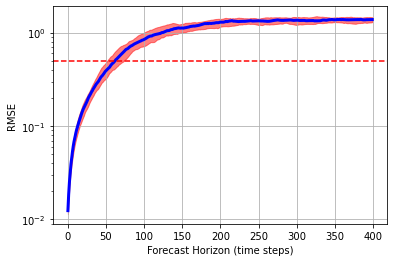

It takes around t = 0.62 for mean error to exceed 0.5


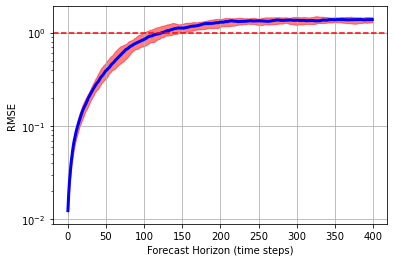

It takes around t = 1.23 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.151
Median NRMSE at t = 0.5: 0.392
Median NRMSE at t = 1: 0.847
Median NRMSE at t = 2: 1.298
Median NRMSE at t = 3: 1.362


In [113]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.3 spec_radius

**Parameters**
- nn_size = 12000
- connectivity = 4
- spec_radius = [0.1, 0.3, 0.5, 0.7]
- lambda = 1e-6

In [114]:
nn_size = 15000
lr_list = [1e-4]
epoch_list = [400]
ridge_penalty = 1e-4

### 3.3.1 spec_radius = 0.1

In [115]:
spec_radius = 0.1

In [116]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 32.55s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 3.85s
W and W_in generated. Time taken: 41.66s

Generating z values...
z values generated. Time taken: 13.58s
Concatenating z with z**2 Contenation complete. Time taken: 2.38s

Epoch 10: Train time = 2.72 | Train Loss = 0.0001812 
Epoch 20: Train time = 2.57 | Train Loss = 0.0000546 
Epoch 30: Train time = 2.73 | Train Loss = 0.0000238 
Epoch 40: Train time = 2.64 | Train Loss = 0.0000123 
Epoch 50: Train time = 2.58 | Train Loss = 0.0000073 
Epoch 51: Train time = 2.57 | Train Loss = 0.0000069 
Epoch 52: Train time = 2.57 | Train Loss = 0.0000066 
Epoch 53: Train time = 2.59 | Train Loss = 0.0000064 
Epoch 54: Train time = 2.59 | Train Loss = 0.0000062 
Epoch 55: Train time = 2.58 | Train Loss = 0.0000059 
Epoch 56: Train time = 2.69 | Train Loss = 0.0000057 
Epoch 57: Train time = 2.57 | Train Loss = 0.0000055 
Epoch 58: Train time = 2.60 | Train Loss = 0.0000053 
Epoch 59: Train time = 2.66 | T

In [117]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 235.59


In [118]:
save_obj(mean_pred, "results/rc", "3_3_1_mu_preds.pkl")

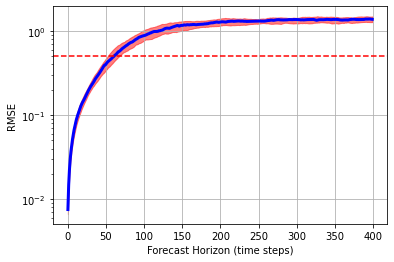

It takes around t = 0.61 for mean error to exceed 0.5


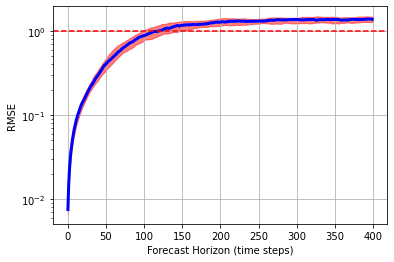

It takes around t = 1.19 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.146
Median NRMSE at t = 0.5: 0.405
Median NRMSE at t = 1: 0.881
Median NRMSE at t = 2: 1.280
Median NRMSE at t = 3: 1.368


In [119]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.2 spec_radius = 0.3

In [120]:
spec_radius = 0.3

In [121]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 32.30s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 2.03s
W and W_in generated. Time taken: 39.39s

Generating z values...
z values generated. Time taken: 12.11s
Concatenating z with z**2 Contenation complete. Time taken: 2.50s

Epoch 10: Train time = 2.75 | Train Loss = 0.0001866 
Epoch 20: Train time = 2.72 | Train Loss = 0.0000565 
Epoch 30: Train time = 2.65 | Train Loss = 0.0000250 
Epoch 40: Train time = 2.71 | Train Loss = 0.0000132 
Epoch 50: Train time = 2.51 | Train Loss = 0.0000080 
Epoch 51: Train time = 2.52 | Train Loss = 0.0000077 
Epoch 52: Train time = 2.53 | Train Loss = 0.0000074 
Epoch 53: Train time = 2.53 | Train Loss = 0.0000071 
Epoch 54: Train time = 2.52 | Train Loss = 0.0000069 
Epoch 55: Train time = 2.53 | Train Loss = 0.0000067 
Epoch 56: Train time = 2.52 | Train Loss = 0.0000064 
Epoch 57: Train time = 2.54 | Train Loss = 0.0000062 
Epoch 58: Train time = 2.51 | Train Loss = 0.0000061 
Epoch 59: Train time = 2.55 | T

In [122]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 235.53


In [123]:
save_obj(mean_pred, "results/rc", "3_3_2_mu_preds.pkl")

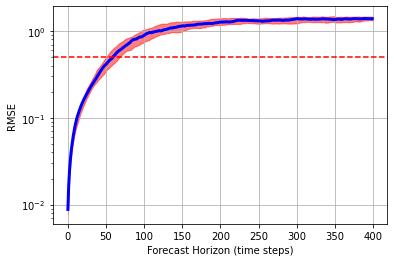

It takes around t = 0.59 for mean error to exceed 0.5


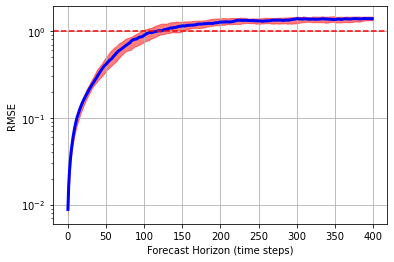

It takes around t = 1.17 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.157
Median NRMSE at t = 0.5: 0.414
Median NRMSE at t = 1: 0.895
Median NRMSE at t = 2: 1.269
Median NRMSE at t = 3: 1.391


In [124]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

### 3.3.3 spec_radius = 0.5
Already done in 3.2.2 / 3.1.5

### 3.3.4 spec_radius = 0.7

In [125]:
spec_radius = 0.7

In [126]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 34.02s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 5.10s
W and W_in generated. Time taken: 44.00s

Generating z values...
z values generated. Time taken: 14.66s
Concatenating z with z**2 Contenation complete. Time taken: 2.88s

Epoch 10: Train time = 2.65 | Train Loss = 0.0002392 
Epoch 20: Train time = 2.65 | Train Loss = 0.0000791 
Epoch 30: Train time = 2.67 | Train Loss = 0.0000402 
Epoch 40: Train time = 2.64 | Train Loss = 0.0000251 
Epoch 50: Train time = 2.57 | Train Loss = 0.0000178 
Epoch 51: Train time = 2.62 | Train Loss = 0.0000173 
Epoch 52: Train time = 2.59 | Train Loss = 0.0000168 
Epoch 53: Train time = 2.57 | Train Loss = 0.0000163 
Epoch 54: Train time = 2.59 | Train Loss = 0.0000161 
Epoch 55: Train time = 2.58 | Train Loss = 0.0000155 
Epoch 56: Train time = 2.57 | Train Loss = 0.0000151 
Epoch 57: Train time = 2.62 | Train Loss = 0.0000148 
Epoch 58: Train time = 2.57 | Train Loss = 0.0000146 
Epoch 59: Train time = 2.56 | T

In [127]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 217.50


In [128]:
save_obj(mean_pred, "results/rc", "3_3_4_mu_preds.pkl")

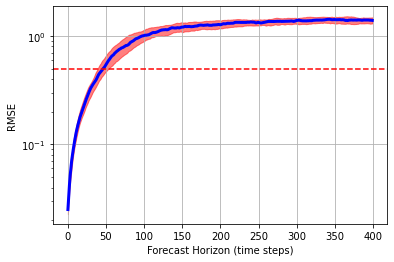

It takes around t = 0.47 for mean error to exceed 0.5


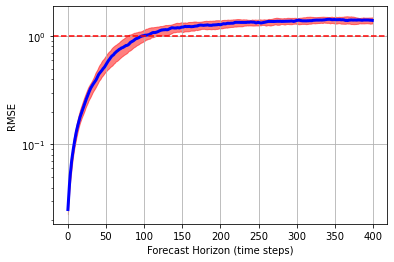

It takes around t = 0.98 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.218
Median NRMSE at t = 0.5: 0.546
Median NRMSE at t = 1: 1.011
Median NRMSE at t = 2: 1.268
Median NRMSE at t = 3: 1.388


In [129]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

## 3.4 connectivity

**Parameters**
- nn_size = 12000
- connectivity = [4, 8]
- spec_radius = ?
- lambda = 1e-6

In [130]:
nn_size = 15000
lr_list = [1e-4]
epoch_list = [400]
ridge_penalty = 1e-4
spec_radius = 0.5

### 3.4.1 connectivity = 4 
Already done in Section 3.3.1

### 3.4.2 connectivity = 8

In [131]:
connectivity = 8

In [132]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 36.90s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 14.06s
W and W_in generated. Time taken: 56.66s

Generating z values...
z values generated. Time taken: 14.45s
Concatenating z with z**2 Contenation complete. Time taken: 4.42s

Epoch 10: Train time = 2.85 | Train Loss = 0.0002098 
Epoch 20: Train time = 2.82 | Train Loss = 0.0000646 
Epoch 30: Train time = 2.82 | Train Loss = 0.0000296 
Epoch 40: Train time = 2.87 | Train Loss = 0.0000163 
Epoch 50: Train time = 2.88 | Train Loss = 0.0000105 
Epoch 51: Train time = 2.76 | Train Loss = 0.0000102 
Epoch 52: Train time = 2.86 | Train Loss = 0.0000099 
Epoch 53: Train time = 2.82 | Train Loss = 0.0000096 
Epoch 54: Train time = 2.87 | Train Loss = 0.0000093 
Epoch 55: Train time = 2.83 | Train Loss = 0.0000090 
Epoch 56: Train time = 2.84 | Train Loss = 0.0000088 
Epoch 57: Train time = 2.86 | Train Loss = 0.0000086 
Epoch 58: Train time = 2.86 | Train Loss = 0.0000084 
Epoch 59: Train time = 2.84 | 

In [133]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 265.50


In [134]:
save_obj(mean_pred, "results/rc", "3_4_2_mu_preds.pkl")

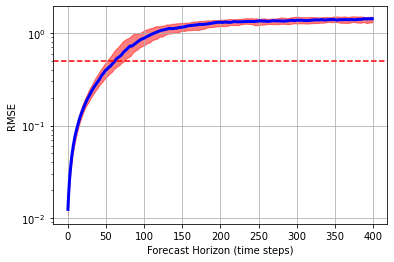

It takes around t = 0.62 for mean error to exceed 0.5


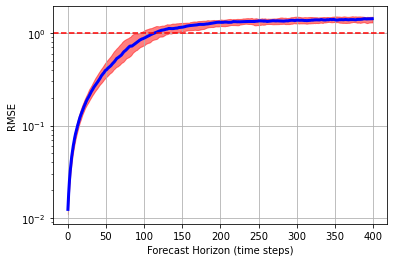

It takes around t = 1.14 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.151
Median NRMSE at t = 0.5: 0.399
Median NRMSE at t = 1: 0.882
Median NRMSE at t = 2: 1.307
Median NRMSE at t = 3: 1.378


In [135]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

# 4. Best model
nn_size = 12000  
beta = 1e-6  
connectivity = 4  
spec_radius = 0.1

In [138]:
nn_size = 15000
ridge_penalty = 1e-4
spec_radius = 0.5
connectivity = 4

lr_list = [1e-4]
epoch_list = [300]

transient = 200  # points to ignore to allow system to stabilise
omega = 1         # scale of the values of matrix W
alpha = 1         # hidden state memory
b_size = 200

In [139]:
params, internal = get_parameters(nn_size, connectivity, spec_radius, lambd = ridge_penalty, seed = SEED, 
                                  batch_size = b_size, num_epoch = epoch_list, lr_schedule = lr_list)

W generated. Time taken: 34.01s
Calculating eigenvalue
Eigenvalue calculated. Time taken: 3.74s
W and W_in generated. Time taken: 42.96s

Generating z values...
z values generated. Time taken: 17.10s
Concatenating z with z**2 Contenation complete. Time taken: 2.47s

Epoch 10: Train time = 2.74 | Train Loss = 0.0002026 
Epoch 20: Train time = 2.74 | Train Loss = 0.0000623 
Epoch 30: Train time = 2.62 | Train Loss = 0.0000286 
Epoch 40: Train time = 2.75 | Train Loss = 0.0000159 
Epoch 50: Train time = 2.75 | Train Loss = 0.0000104 
Epoch 51: Train time = 2.74 | Train Loss = 0.0000101 
Epoch 52: Train time = 2.72 | Train Loss = 0.0000097 
Epoch 53: Train time = 2.78 | Train Loss = 0.0000094 
Epoch 54: Train time = 2.76 | Train Loss = 0.0000092 
Epoch 55: Train time = 2.78 | Train Loss = 0.0000090 
Epoch 56: Train time = 2.69 | Train Loss = 0.0000087 
Epoch 57: Train time = 2.69 | Train Loss = 0.0000085 
Epoch 58: Train time = 2.70 | Train Loss = 0.0000083 
Epoch 59: Train time = 2.79 | T

In [140]:
_, W_in, W = internal
mean_pred = get_test_pred(X_test, nn_size, params, W_in, W)

10.00% done
20.00% done
30.00% done
40.00% done
50.00% done
60.00% done
70.00% done
80.00% done
90.00% done
100.00% done
Testing complete. Time taken: 240.77


In [141]:
save_obj(mean_pred, "results/rc", "best_mu_preds.pkl")
save_obj(W, "results/rc", "best_W.pkl")
save_obj(W_in, "results/rc", "best_W_in.pkl")
save_obj(params, "results/rc", "best_params.pkl")

In [142]:
# W = load_obj("results/rc/best_W.pkl")
# W_in = load_obj("results/rc/best_W_in.pkl")
# params = load_obj("results/rc/best_params.pkl")

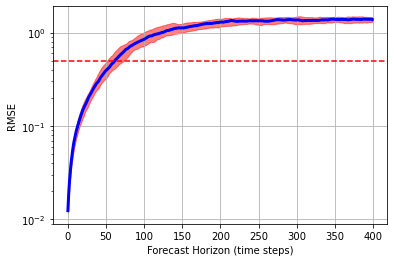

It takes around t = 0.62 for mean error to exceed 0.5


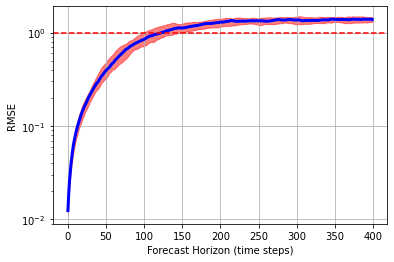

It takes around t = 1.23 for mean error to exceed 1.0

Median NRMSE at t = 0.2: 0.151
Median NRMSE at t = 0.5: 0.393
Median NRMSE at t = 1: 0.847
Median NRMSE at t = 2: 1.295
Median NRMSE at t = 3: 1.363


In [143]:
desc_name = "rc_nn" + str(nn_size)
res_single = PointExperimentResult(mean_pred - y_test, desc_name)
res_single.plot_rmse(error_thresh = 0.5)
res_single.plot_rmse(error_thresh = 1.)
print()
res_single.get_loss([0.2, 0.5, 1, 2, 3])

**check disk space**

In [112]:
def get_size(start_path = '.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(start_path):
        for f in filenames:
            fp = os.path.join(dirpath, f)
            # skip if it is symbolic link
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)

    return total_size

print(get_size("results/rc") / (2**30), 'GiB')

0.08522220607846975 GiB


In [113]:
import shutil

total, used, free = shutil.disk_usage("/")

print("Total: %d GiB" % (total // (2**30)))
print("Used: %d GiB" % (used // (2**30)))
print("Free: %d GiB" % (free // (2**30)))

Total: 192 GiB
Used: 173 GiB
Free: 9 GiB


# 5. Plot images based on Lyapunov Time

In [12]:
mean_pred = load_obj("results/rc/best_mu_preds.pkl")

In [13]:
save_obj(mean_pred, "results", "rc_pred.pkl")

In [14]:
total_lyapunov_time_pred = 4 / LORENZ_LT # Amount of Lyapunov Time in Test set

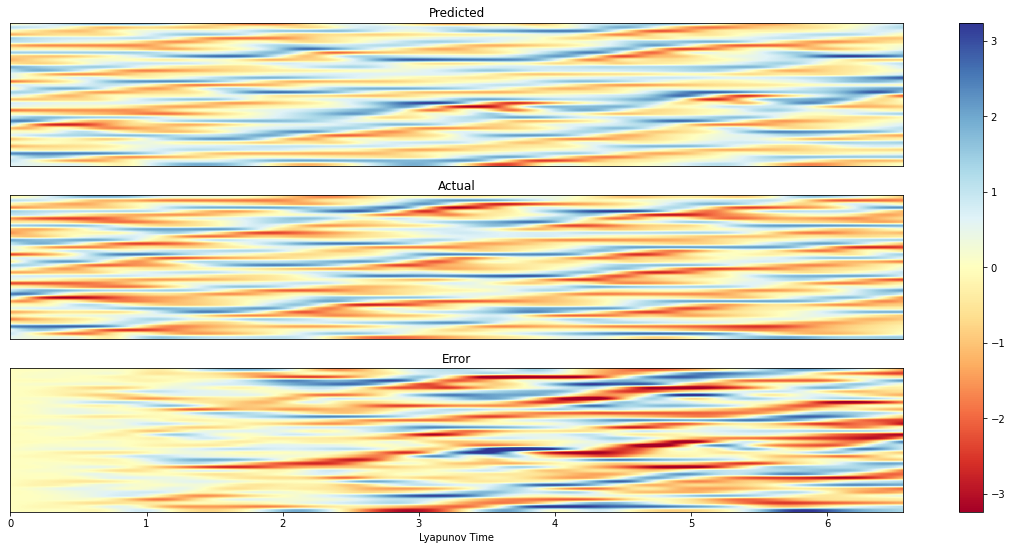

In [15]:
plot_predictions(mean_pred, y_test, total_lyapunov_time_pred, save_name = "Lorenz_Small_RC")

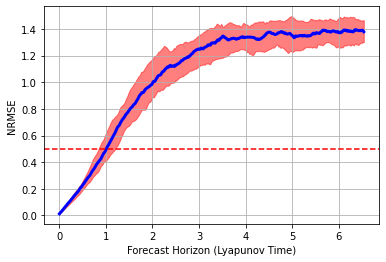

It takes around 1.02 Lyapunov Time for mean error to exceed 0.5

Median NRMSE at 0.5 Lyapunov Time: 0.223
Median NRMSE at 1.0 Lyapunov Time: 0.493
Median NRMSE at 2.0 Lyapunov Time: 0.992
Median NRMSE at 5.0 Lyapunov Time: 1.352


In [16]:
res_single = PointExperimentResultLyapunov(mean_pred - y_test, "lorenz")
res_single.plot_rmse(save_name = "Lorenz_Small_RC_PH")
print()
res_single.get_loss()